Now go one step further. The previous data has got 2D, while the real exp data might not have such rich information. Therefore we now try to apply 1D curve to see the accuracy.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.ndimage import gaussian_filter

good_data_small = np.load('datasets/True_majsts_data_small.npy')
good_data_large = np.load('datasets/True_majsts_data_large.npy')
bad_data_small = np.load('datasets/Andreev_majsts_data_small.npy')
bad_data_large = np.load('datasets/Andreev_majsts_data_large.npy')
ugly_data_small = np.load('datasets/Ugly_majsts_data_small.npy')
ugly_data_large = np.load('datasets/Ugly_majsts_data_large.npy')

good_data = np.concatenate([good_data_small, good_data_large], axis=0)
bad_data = np.concatenate([bad_data_small, bad_data_large], axis=0)
ugly_data = np.concatenate([ugly_data_small, ugly_data_large], axis=0)

N1, N2, N3 = len(good_data), len(bad_data), len(ugly_data)
data_2D = np.concatenate([good_data, bad_data, ugly_data], axis=0)

N, M = len(data_2D), 28
# we can keep the order, because scikit can shuffle them later
labels_2D = np.concatenate([np.ones(N1), np.zeros(N2), np.zeros(N3)])

# sigma=3, ampl=0.1
for i in range(N):
    data_2D[i] = gaussian_filter(data_2D[i], sigma=2)

np.shape(data_2D)

(12000, 28, 28)

Let's make the 1D data clean first, to test the machine learning power on much less information.

How to find the peak? Simple: Find the max value for zero bias energy (vertical axis), and extract it.

In [2]:
data_1D = []
labels = []
for i in range(N):
    for j in range(M):
        route = data_2D[i][:, j]
        if np.argmax(route) == M // 2 and max(route) >= 1.8:
            route += 0 * np.random.normal(size=28)
            data_1D.append(route)
            labels.append(labels_2D[i])

data_1D = np.array(data_1D)
labels = np.array(labels)

print(np.shape(data_1D))
print(np.sum(labels))

(21322, 28)
12978.0


View some curves.

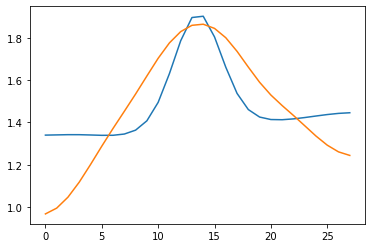

In [3]:
plt.plot(range(28), data_1D[np.random.randint(0, 1906)])
plt.plot(range(28), data_1D[np.random.randint(1997, 3000)])

Now PCA first for 2D.

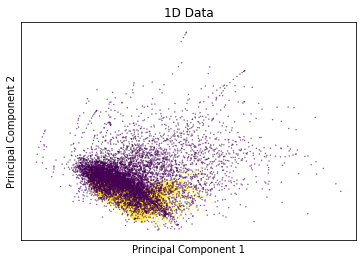

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_1D)

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels.ravel(), s=0.1, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('1D Data')
plt.xticks([])
plt.yticks([])
#plt.colorbar(label='Label')
#plt.savefig('1dbefore_anomaly.png')
plt.show()

2D PCA is no longer sufficient for classification.

We can use **Anomaly Detection** method to eliminate some unrealistic data out of the training dataset.

For example, we use Isolation Forest to post process.

(21322,) (21322,)


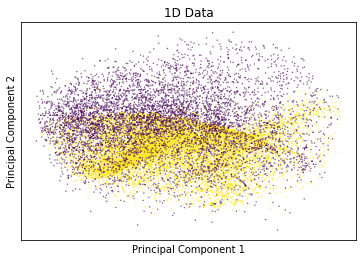

In [5]:
from sklearn.ensemble import IsolationForest
clf = IsolationForest(n_estimators=100, max_samples='auto', contamination=0.1, random_state=42)
clf.fit(data_1D)

# filter
predictions = clf.predict(data_1D)
print(np.shape(predictions), np.shape(labels))
data = data_1D[predictions == 1]
np.save('1dtrainingdata.npy', data)

data_pca = pca.fit_transform(data)
labels = labels[predictions == 1]
np.save('1dtraininglabel.npy', labels)

plt.scatter(data_pca[:, 0], data_pca[:, 1], c=labels.ravel(), s=0.1, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('1D Data')
plt.xticks([])
plt.yticks([])
#plt.colorbar(label='Label')
#plt.savefig('1dafter_anomaly.png')
plt.show()

Accuracy: 0.7799082951229679


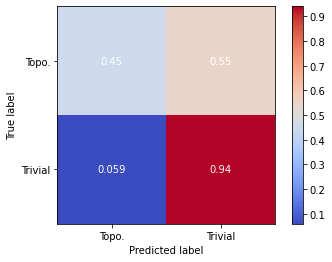

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)
X_train, X_test, y_train, y_test = train_test_split(data_pca, labels.ravel(), test_size=0.25, random_state=42)

# Create a SVC with a linear kernel
svm = SVC(kernel='linear')

# Train the model
svm.fit(X_train, y_train)

# Predict on the test data
y_pred = svm.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=['Topo.', 'Trivial']).plot(cmap='coolwarm')

# Change text colors
for text in disp.text_:
    for subtext in text:
        subtext.set_color('white')

plt.savefig('1dlinear_confusion.svg')
# Check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Great job! Now try random forest.

In [7]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classifier
clf = RandomForestClassifier(n_estimators=200, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(data, labels.ravel(), test_size=0.25, random_state=42)
# Train the model on the PCA-transformed data
clf.fit(X_train, y_train)

# Predict on the test data
y_pred = clf.predict(X_test)
# Check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

Accuracy: 0.8822426010837849


Try xgboost.

Accuracy: 0.8609837432263443


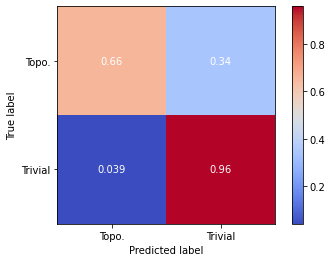

In [9]:
import xgboost as xgb
import pickle
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(data, labels.ravel(), test_size=0.25, random_state=42)

# Create DMatrix for train data
dmatrix_train = xgb.DMatrix(data=X_train, label=y_train)
dmatrix_test = xgb.DMatrix(data=X_test, label=y_test)  # Optional, for evaluation

# Set the parameters
params = {
    'objective': 'binary:logistic',
    'max_depth': 6,
    'eta': 0.1,
    "subsample": 1,
    "gamma": 5,
    "lambda": 0,
    "alpha": 0.3
}
# Train the final model
bst = xgb.train(params, dmatrix_train, num_boost_round=200)

# Make predictions on test data
y_pred = bst.predict(dmatrix_test)
y_pred = np.array([1 if p > 0.5 else 0 for p in y_pred])


# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')

# Display the confusion matrix
disp = ConfusionMatrixDisplay(cm, display_labels=['Topo.', 'Trivial']).plot(cmap='coolwarm')

# Change text colors
for text in disp.text_:
    for subtext in text:
        subtext.set_color('white')

plt.savefig('1dboost_confusion.svg')
# Check the accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)


with open('clf_xgboost_1d.pickle', 'wb') as f:
    pickle.dump(bst, f)

Well, not bad! Start plotting for boundary PCA:

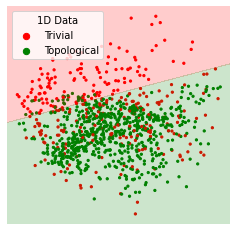

In [ ]:
from sklearn.svm import SVC

# Control the figure size
plt.figure(figsize=(4, 4))

# Randomly pick a subset of data points
n_samples = 1000  # Number of samples you want to plot
random_indices = np.random.choice(data_pca.shape[0], n_samples, replace=False)
subset_data_pca = data_pca[random_indices, :]
subset_labels = labels[random_indices]

# Fit Linear SVM
clf = SVC(kernel='linear', C=1)
clf.fit(subset_data_pca, subset_labels)

# Plotting points
colors = ['red' if label == 0 else 'green' for label in subset_labels]
plt.scatter(subset_data_pca[:, 0], subset_data_pca[:, 1], c=colors, s=5)

# Plotting the decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                     np.linspace(ylim[0], ylim[1], 50))
Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot filled contour. Note the use of levels to create areas.
ax.contourf(xx, yy, Z, levels=[-np.inf, 0, np.inf], colors=['red', 'green'], alpha=0.2)

# Hide the axes
plt.axis('off')

# Legend
for color, label in zip(['red', 'green'], ['Trivial', 'Topological']):
    plt.scatter([], [], c=color, s=40, label=label)
plt.legend(scatterpoints=1, title='1D Data')

plt.savefig('1dpca.svg')
plt.show()